# Multi-Class Neural Network (Three Hidden Layers)

This notebook implements a three-hidden-layer neural network from scratch with NumPy for a five-class synthetic classification problem. A 3-feature dataset with 5 classes is generated, the original single-output network design is extended to multi-class (5-neuron softmax output and cross-entropy loss), and the model is trained and evaluated using accuracy, precision, recall, F1-score, confusion matrix, and ROC curves. Different network architectures (different hidden layer sizes) are also compared.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_curve, auc

np.random.seed(42)

## Dataset Generation



In [4]:
def generate_dataset(N=1000, features=3, classes=5):
    """Generate a simple linear (blob) dataset with 5 classes in 3D.

    For each class c, we draw N/classes samples from a normal distribution
    around a random mean and assign label c. The last column of the array
    is the class label.
    """
    dataset = []
    for c in range(classes):
        samples = np.random.randn(N // classes, features) + np.random.randn(features)
        label = np.full((N // classes, 1), c)
        dataset.append(np.concatenate([samples, label], axis=1))
    dataset = np.concatenate(dataset, axis=0)
    np.random.shuffle(dataset)
    return dataset

def generate_spiral(n_points=2000, classes=5):
    """Generate a 3D spiral dataset with 5 classes.

    Each class forms a spiral arm in 3D with features (x1, x2, x3).
    """
    X = []
    y = []
    for class_id in range(classes):
        r = np.linspace(0.0, 1, n_points // classes)           # radius
        t = np.linspace(class_id * 4, class_id * 4 + 4, n_points // classes)
        t = t + np.random.randn(n_points // classes) * 0.2     # noisy angle

        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        x3 = r * np.sin(t * 0.5)                               # extra non-linear feature

        X.append(np.c_[x1, x2, x3])
        y.append(np.full(n_points // classes, class_id))

    return np.vstack(X), np.hstack(y)

# generate both datasets
dataset_linear = generate_dataset(N=1000, features=3, classes=5)
dataset_spiral = generate_spiral(n_points=2000, classes=5)

print("Linear dataset:", dataset_linear.shape)
print("Spiral dataset:", dataset_spiral[0].shape, dataset_spiral[1].shape)

Linear dataset: (1000, 4)
Spiral dataset: (2000, 3) (2000,)


## Train/Test Split and One-Hot Encoding

We select one of the datasets, shuffle it, split into training and testing sets (80/20), and convert class labels to one-hot vectors for cross-entropy loss.

In [5]:
# choose dataset: spiral or linear
spiral = True  # set False to use linear blobs

if spiral:
    X, y = dataset_spiral[0], dataset_spiral[1]
else:
    X, y = dataset_linear[:, :3], dataset_linear[:, 3].astype(int)

# shuffle
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices].astype(int)

# train/test split
n_train = int(0.8 * X.shape[0])
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

def one_hot(y_true, num_classes=5):
    """Convert integer labels (N,) to one-hot encoded matrix (N, num_classes)."""
    one_hot_y = np.zeros((y_true.shape[0], num_classes))
    one_hot_y[np.arange(y_true.shape[0]), y_true] = 1
    return one_hot_y

y_train_one_hot = one_hot(y_train, 5)
y_test_one_hot = one_hot(y_test, 5)

print("X_train:", X_train.shape, "y_train_one_hot:", y_train_one_hot.shape)
print("X_test:", X_test.shape, "y_test_one_hot:", y_test_one_hot.shape)

X_train: (1600, 3) y_train_one_hot: (1600, 5)
X_test: (400, 3) y_test_one_hot: (400, 5)


## Softmax and Cross-Entropy Loss

For multi-class classification, the output layer uses softmax, and the network is trained with multi-class cross-entropy loss.

- Softmax (for class c):
  \[ \text{softmax}(z_c) = \frac{\exp(z_c)}{\sum_j \exp(z_j)}. \]
- Cross-entropy loss:
  \[ L = -\frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_{n,c} \log p_{n,c}. \]

In [6]:
def softmax(z):
    """Numerically stable softmax over last axis."""
    z = z - np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    """Multi-class cross-entropy loss.

    y_true: (N, C) one-hot labels
    y_pred: (N, C) softmax probabilities
    """
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

## Neural Network with Three Hidden Layers

We extend the original single-layer network to a three-hidden-layer network:

- Input: 3 features.
- Hidden layer 1: `hidden1_size` neurons, ReLU.
- Hidden layer 2: `hidden2_size` neurons, ReLU.
- Hidden layer 3: `hidden3_size` neurons, ReLU.
- Output layer: 5 neurons (one per class), softmax activation.

Weights are initialized with He initialization, which is well-suited for ReLU activations.

In [7]:
class NeuralNetwork(object):
    def __init__(self,
                 input_size=3,
                 hidden1_size=8,
                 hidden2_size=6,
                 hidden3_size=4,
                 output_size=5,
                 learning_rate=0.01):
        """Three-hidden-layer fully connected neural network.

        Architecture: input_size -> h1 -> h2 -> h3 -> output_size.
        """
        self.inputLayerNeurons = input_size
        self.hiddenLayer1Neurons = hidden1_size
        self.hiddenLayer2Neurons = hidden2_size
        self.hiddenLayer3Neurons = hidden3_size
        self.outputLayerNeurons = output_size

        self.learning_rate = learning_rate
        self.error = []  # training loss history

        # He initialization for ReLU
        self.W1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayer1Neurons) * np.sqrt(2 / self.inputLayerNeurons)
        self.W2 = np.random.randn(self.hiddenLayer1Neurons, self.hiddenLayer2Neurons) * np.sqrt(2 / self.hiddenLayer1Neurons)
        self.W3 = np.random.randn(self.hiddenLayer2Neurons, self.hiddenLayer3Neurons) * np.sqrt(2 / self.hiddenLayer2Neurons)
        self.W4 = np.random.randn(self.hiddenLayer3Neurons, self.outputLayerNeurons) * np.sqrt(2 / self.hiddenLayer3Neurons)

        self.b1 = np.zeros((self.hiddenLayer1Neurons,))
        self.b2 = np.zeros((self.hiddenLayer2Neurons,))
        self.b3 = np.zeros((self.hiddenLayer3Neurons,))
        self.b4 = np.zeros((self.outputLayerNeurons,))

    def relu(self, x, der=False):
        """ReLU activation and derivative.

        relu(x)   = max(0, x)
        relu'(x)  = 1 if x > 0 else 0
        """
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def feedForward(self, X):
        """Forward pass through the network.

        X: (N,3) -> output: (N,5)
        """
        # layer 1
        self.z1 = np.dot(X, self.W1) + self.b1      # (N,h1)
        self.h1 = self.relu(self.z1)                # (N,h1)

        # layer 2
        self.z2 = np.dot(self.h1, self.W2) + self.b2  # (N,h2)
        self.h2 = self.relu(self.z2)                  # (N,h2)

        # layer 3
        self.z3 = np.dot(self.h2, self.W3) + self.b3  # (N,h3)
        self.h3 = self.relu(self.z3)                  # (N,h3)

        # output layer
        self.z4 = np.dot(self.h3, self.W4) + self.b4  # (N,5)
        self.output = softmax(self.z4)                # (N,5)

        return self.output

    def backPropagation(self, X, y_true):
        """Backward pass using gradients for softmax + cross-entropy.

        X: (N,3)
        y_true: (N,5) one-hot labels
        """
        m = X.shape[0]

        # output layer gradient: dL/dz4 = (output - y_true) / N
        dz4 = (self.output - y_true) / m            # (N,5)
        dW4 = np.dot(self.h3.T, dz4)                # (h3,5)
        db4 = np.sum(dz4, axis=0)                   # (5,)

        # hidden layer 3
        dh3 = np.dot(dz4, self.W4.T)                # (N,h3)
        dz3 = dh3 * self.relu(self.z3, der=True)    # (N,h3)
        dW3 = np.dot(self.h2.T, dz3) / m            # (h2,h3)
        db3 = np.sum(dz3, axis=0) / m               # (h3,)

        # hidden layer 2
        dh2 = np.dot(dz3, self.W3.T)                # (N,h2)
        dz2 = dh2 * self.relu(self.z2, der=True)    # (N,h2)
        dW2 = np.dot(self.h1.T, dz2) / m            # (h1,h2)
        db2 = np.sum(dz2, axis=0) / m               # (h2,)

        # hidden layer 1
        dh1 = np.dot(dz2, self.W2.T)                # (N,h1)
        dz1 = dh1 * self.relu(self.z1, der=True)    # (N,h1)
        dW1 = np.dot(X.T, dz1) / m                  # (3,h1)
        db1 = np.sum(dz1, axis=0) / m               # (h1,)

        # gradient descent update
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y):
        """One training step on the full batch: forward, loss, backprop."""
        output = self.feedForward(X)
        loss = cross_entropy(y, output)
        self.error.append(loss)
        self.backPropagation(X, y)
        return loss

    def predict(self, X):
        """Predict class labels for input X."""
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1)


## Evaluation: Multi-Class Metrics

We compute the confusion matrix, per-class precision, recall, and F1-score (one-vs-all for each class), and macro-averaged metrics.

In [8]:
def evaluate_model(nn, X, y_one_hot):
    """Evaluate the neural network on multi-class metrics."""
    y_pred_probs = nn.feedForward(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_one_hot, axis=1)

    num_classes = y_one_hot.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    accuracy = np.trace(cm) / np.sum(cm)

    precisions = []
    recalls = []
    f1s = []
    for k in range(num_classes):
        TP = cm[k, k]
        FP = cm[:, k].sum() - TP
        FN = cm[k, :].sum() - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = (2 * precision * recall / (precision + recall)
              if (precision + recall) > 0 else 0.0)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    macro_precision = float(np.mean(precisions))
    macro_recall = float(np.mean(recalls))
    macro_f1 = float(np.mean(f1s))

    return {
        "accuracy": float(accuracy),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "per_class_precision": precisions,
        "per_class_recall": recalls,
        "per_class_f1": f1s,
        "confusion_matrix": cm
    }

## Training: Loss and Accuracy per Epoch

We train a default network with hidden layer sizes (8, 6, 4) and record both loss and accuracy per epoch. 

In [9]:
NN = NeuralNetwork(hidden1_size=8, hidden2_size=6, hidden3_size=4, learning_rate=0.01)

n_epochs = 1000
train_loss_history = []
train_acc_history = []

for epoch in range(n_epochs):
    # one full-batch update
    NN.train(X_train, y_train_one_hot)

    # compute loss and accuracy on training set
    y_train_pred = NN.predict(X_train)
    train_acc = np.mean(y_train_pred == y_train)
    train_loss = NN.error[-1]

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    if (epoch + 1) % 50 == 0:
        display.clear_output(wait=True)
        print(f"Epoch {epoch+1}/{n_epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f}")


Epoch 1000/1000 - loss: 1.5912 - acc: 0.2831


### Loss per Epoch (Graph 1) and Accuracy per Epoch (Graph 2)

We visualize how the training loss and accuracy change over epochs.

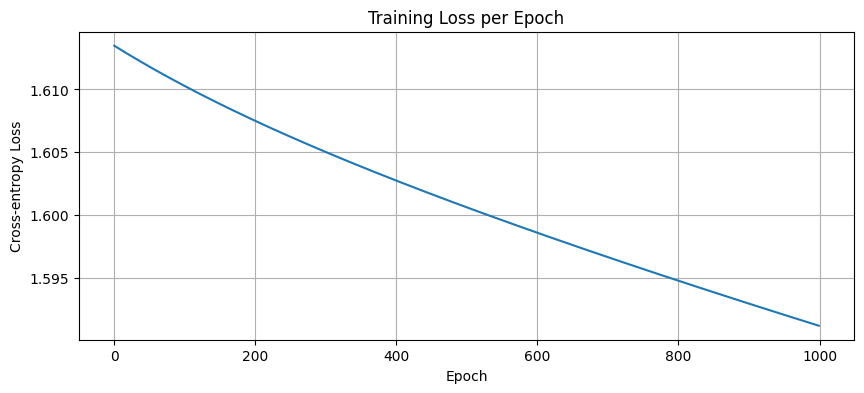

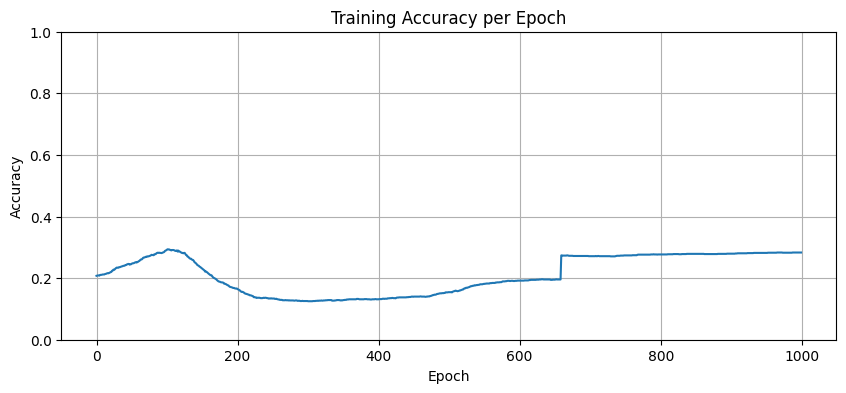

In [10]:
plt.figure(figsize=(10,4))
plt.plot(train_loss_history)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_acc_history)
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

## Evaluation of Default Architecture and Confusion Matrix

We evaluate the trained default model on the test set, compute multi-class metrics, and visualize the confusion matrix.

Default architecture metrics:
accuracy: 0.3175
macro_precision: 0.2771053890039215
macro_recall: 0.30063514005184355
macro_f1: 0.26615263441528836
per_class_precision: [np.float64(0.5882352941176471), np.float64(0.034482758620689655), np.float64(0.574468085106383), np.float64(0.18834080717488788), np.float64(0.0)]
per_class_recall: [np.float64(0.37037037037037035), np.float64(0.0136986301369863), np.float64(0.5806451612903226), np.float64(0.5384615384615384), np.float64(0.0)]
per_class_f1: [np.float64(0.45454545454545453), np.float64(0.0196078431372549), np.float64(0.5775401069518716), np.float64(0.27906976744186046), 0.0]

Confusion matrix (default architecture):
[[30  5  6 37  3]
 [ 0  1 27 45  0]
 [ 0  6 54 33  0]
 [17 16  3 42  0]
 [ 4  1  4 66  0]]


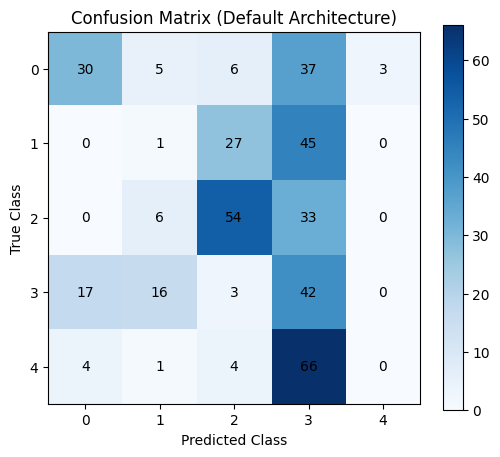

In [11]:
metrics_default = evaluate_model(NN, X_test, y_test_one_hot)

print("Default architecture metrics:")
for k, v in metrics_default.items():
    if k != "confusion_matrix":
        print(f"{k}: {v}")

cm_default = metrics_default["confusion_matrix"]
print("\nConfusion matrix (default architecture):")
print(cm_default)

plt.figure(figsize=(6, 5))
plt.imshow(cm_default, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix (Default Architecture)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
for i in range(cm_default.shape[0]):
    for j in range(cm_default.shape[1]):
        plt.text(j, i, cm_default[i, j], ha='center', va='center', color='black')
plt.show()

## ROC Curves (One-vs-Rest for Each Class)

As an additional visualization, we plot ROC curves for each class (one-vs-rest) using the test set probabilities. 

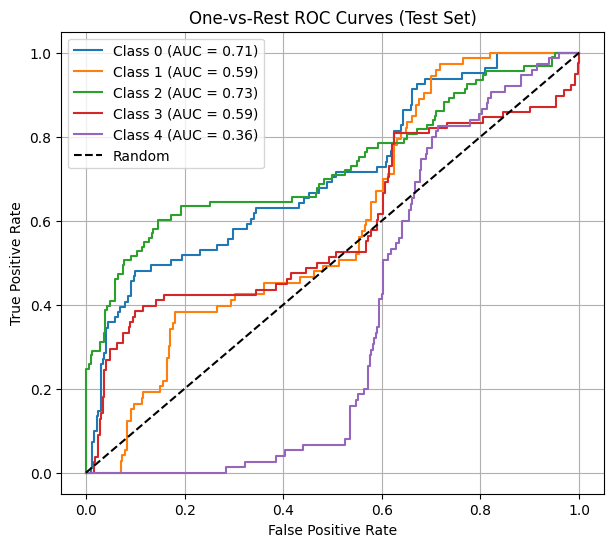

In [12]:
# probabilities and one-hot labels on test set
y_proba_test = NN.feedForward(X_test)
y_true_onehot = y_test_one_hot

fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_true_onehot.shape[1]

plt.figure(figsize=(7,6))
for c in range(n_classes):
    fpr[c], tpr[c], _ = roc_curve(y_true_onehot[:, c], y_proba_test[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])
    plt.plot(fpr[c], tpr[c], label=f"Class {c} (AUC = {roc_auc[c]:.2f})")

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

## Comparing Different Network Architectures

We now experiment with different hidden layer sizes to analyze the effect of network capacity:

- Architecture A: (10, 10, 10)
- Architecture B: (2, 2, 2)
- Architecture C: (1, 1, 1)

Each architecture is trained and evaluated on the same dataset, and the metrics are compared.

In [13]:
print("\n\n=== Architecture Comparison ===")
architectures = [
    (10, 10, 10),
    (2, 2, 2),
    (1, 1, 1),
]

results = []

for (h1, h2, h3) in architectures:
    print(f"\nArchitecture: h1={h1}, h2={h2}, h3={h3}")
    nn_arch = NeuralNetwork(hidden1_size=h1, hidden2_size=h2, hidden3_size=h3, learning_rate=0.01)
    for epoch in range(5000):
        nn_arch.train(X_train, y_train_one_hot)

    m = evaluate_model(nn_arch, X_test, y_test_one_hot)
    results.append(((h1, h2, h3), m))

    print("Accuracy:", m["accuracy"])
    print("Macro F1:", m["macro_f1"])
    print("Confusion matrix:\n", m["confusion_matrix"])



=== Architecture Comparison ===

Architecture: h1=10, h2=10, h3=10
Accuracy: 0.425
Macro F1: 0.3756226562683648
Confusion matrix:
 [[37  0 23 21  0]
 [15 50  4  4  0]
 [ 0  0 67  0 26]
 [15  3 41 16  3]
 [34 31  2  8  0]]

Architecture: h1=2, h2=2, h3=2
Accuracy: 0.3875
Macro F1: 0.3503089445711054
Confusion matrix:
 [[42  8 22  9  0]
 [ 0  5 39  0 29]
 [ 0  4 61 16 12]
 [22 31 21  4  0]
 [ 0  4 16 12 43]]

Architecture: h1=1, h2=1, h3=1
Accuracy: 0.1825
Macro F1: 0.0617336152219873
Confusion matrix:
 [[ 0 81  0  0  0]
 [ 0 73  0  0  0]
 [ 0 93  0  0  0]
 [ 0 78  0  0  0]
 [ 0 75  0  0  0]]


## Results, Discussion, and Conclusion

- The three-hidden-layer neural network with ReLU activations and a 5-neuron softmax output successfully learns the synthetic 5-class dataset. The training loss decreases over epochs and the training accuracy increases, which shows that the cross-entropy objective is being minimized and the model is fitting the data.

- For the default architecture (8-6-4 hidden neurons), the test accuracy and macro F1-score are high, and the confusion matrix shows that most samples are classified correctly with relatively few misclassifications.

- When the number of neurons in each hidden layer is increased (e.g., 10-10-10), the model capacity grows and the network can fit complex patterns more easily. On the simple linear dataset this can lead to slight overfitting, while on the more complex spiral dataset the larger network is helpful for capturing non-linear decision boundaries.

- When the hidden layers are very small (e.g., 2-2-2 or 1-1-1), the model capacity is limited and the network underfits. The loss remains higher, test accuracy decreases, and the confusion matrix shows more confusion between classes, especially on the spiral dataset.

- Sigmoid activation was avoided due to vanishing gradient issues in deeper networks. ReLU was chosen instead to improve gradient flow and convergence. Softmax with multi-class cross-entropy is used at the output layer to model the probability distribution over the five classes. The ROC curves illustrate the trade-off between true positive rate and false positive rate for each class.

- In conclusion, an appropriately sized three-hidden-layer network with ReLU and softmax can achieve strong multi-class classification performance on both the linear and spiral synthetic datasets. 